In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

We define a "asset crash" as a huge daily change in price ( > 5 standard deviations from the mean over the last trading year).

We're applying the same method illustrated in Mandelbrot's "The Misbehaviour Of Markets" (2008, Mathematical appendix).

The goal is to show how unlikely a high price change is according to a normal distribution. This in turn provides evidence of the uselessness of using a normal distribution to quantify risk.

First some code to import prices for individual assets from Yahoo.

In [3]:
 def import_asset_data(tickers, start = '2010-1-1'):
    """
    Imports data of a list of assets from a certain date.
    
    Parameters
    ----------
    tickers : list of str
        List of tickers for asset prices
    start : str
        Date in yyyy-MM-dd format
        
    Returns
    -------
    pandas.DataFrame
    """
    data = pd.DataFrame()
    if len([tickers]) ==1:
        data[tickers] = wb.DataReader(tickers, data_source='yahoo', start = start)['Adj Close']
        #data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = wb.DataReader(t, data_source='yahoo', start = start)['Adj Close']
    return(data)

Import BTC data from Yahoo

In [21]:
asset = ['BTC-USD']
data = import_asset_data(asset)

In [22]:
data.head()

,BTC-USD
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


Plot price.

<AxesSubplot: xlabel='Date'>

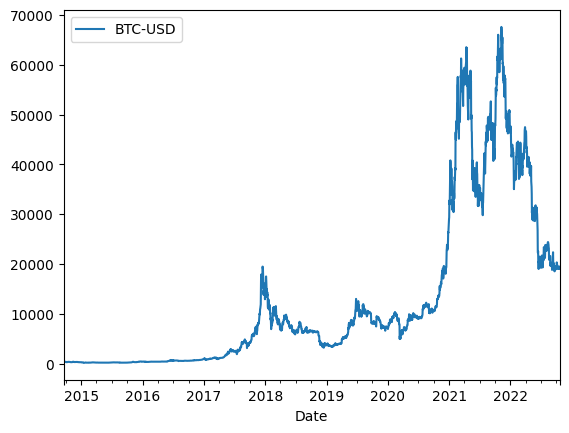

In [23]:
data[asset].plot()

Compute logarithm of prices and plot daily changes. We're interested in modeling price changes, not price itself.

<AxesSubplot: xlabel='Date'>

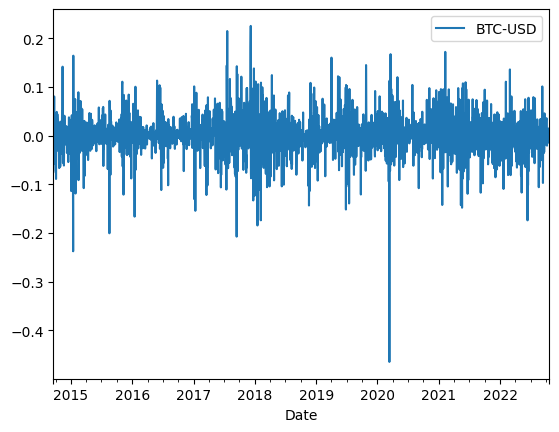

In [24]:
log_data = np.log(data[asset])
log_data_diff = log_data.diff().dropna()
log_data_diff.plot()

Define window length to be used in all subsequent computations. We consider mean, volatility, etc., over the course of one trading year (250 days).

In [25]:
window_length = 250

Compute mean.

<AxesSubplot: xlabel='Date'>

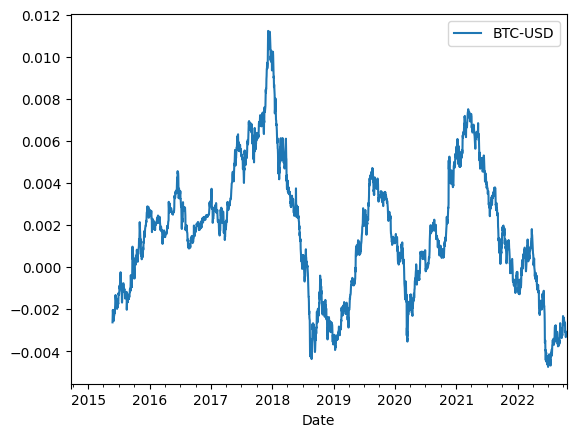

In [26]:
mean = log_data_diff.rolling(window_length).mean()
mean.plot()

Compute variance (as if it would fit the bell curve).

<AxesSubplot: xlabel='Date'>

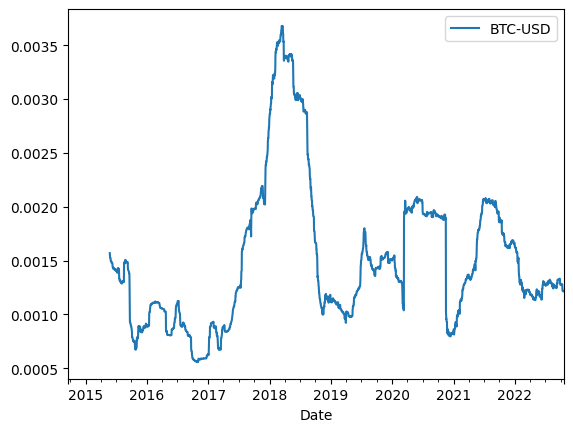

In [27]:
var = log_data_diff.rolling(window_length).var()
var.plot()

Compute standard deviation.

<AxesSubplot: xlabel='Date'>

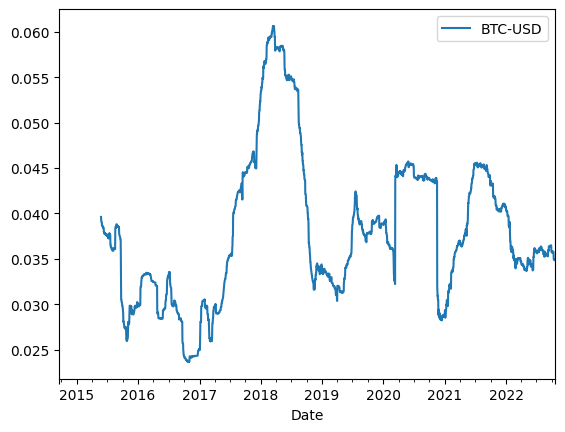

In [28]:
std = log_data_diff.rolling(window_length).std()
std.plot()

As we can see from this plots, variance varies wildly.

Find number of standard deviations from the mean for each day (z-score). We start after the first year, minus one because we're dealing with price changes. z-score measures how much each day is distant from the mean, expressed in standard deviations over the previous year.

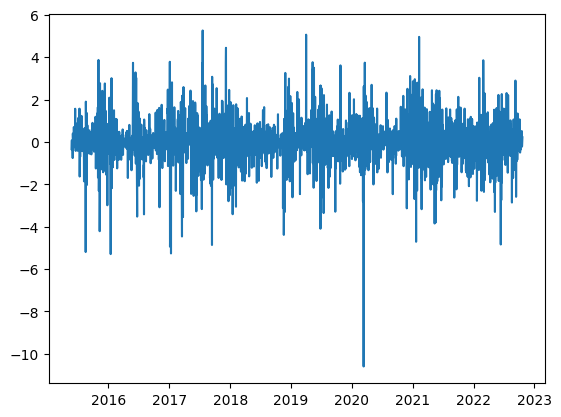

In [29]:
zscores = (log_data_diff[window_length-1:] - mean) / std
#zscores = st.zscore(log_data_diff.dropna().to_numpy())
plt.plot(zscores)

Find crashes (events with absolute high z-score, but in the negative).

In [32]:
crashes = pd.DataFrame() 
crashes[asset] = zscores[asset][zscores < -5]

Find probability of each crash. That is, getting a daily change as extreme as those in the data. We're considering those at least 5 standard deviations apart.

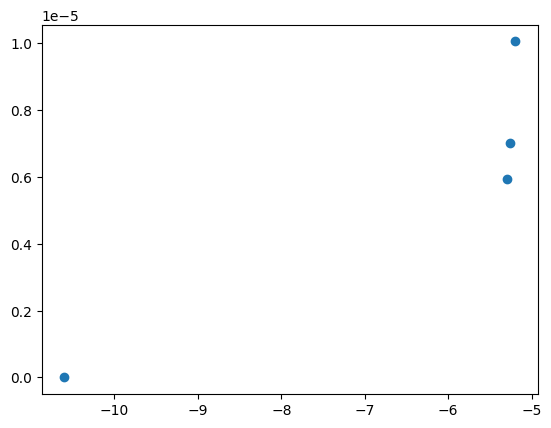

In [33]:
zscores_prob = pd.DataFrame()
zscores_prob[asset] = st.norm(0, 1).cdf(crashes)
for a in asset:
    plt.scatter(crashes[a], zscores_prob[a]*100) # percentage

If price changes really did follow a normal distributions, such crashes would be almost impossible (even considering the most probable, that's still a 0.00001% probability of such a crash).